In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

# 8.3 Lab: Decision Trees

**8.3.1 Fitting Classification Trees**

> library(tree)

> library(ISLR)

> attach(Carseats )



In [3]:
Carseats = pd.read_csv("data/Carseats.csv")
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


> High=ifelse(Sales <=8,"No","Yes")

In [4]:
#方法一
High = [('No' if Sales <= 8 else 'yes') for Sales in Carseats.Sales]
High[:5]

['yes', 'yes', 'yes', 'No', 'No']

In [5]:
#方法二
High = Carseats.Sales.map(lambda x: 'No' if x <= 8 else 'yes')
High[:5]

0    yes
1    yes
2    yes
3     No
4     No
Name: Sales, dtype: object

In [6]:
#方法三
High = pd.cut(Carseats.Sales,[Carseats.Sales.min(),8,Carseats.Sales.max()],right=True,labels = ['No','Yes'])
High[:5]

0    Yes
1    Yes
2    Yes
3     No
4     No
Name: Sales, dtype: category
Categories (2, object): [No < Yes]

In [7]:
#方法四
High = np.where(Carseats.Sales<=8,'No','Yes')
High[:5]

array(['Yes', 'Yes', 'Yes', 'No', 'No'], dtype='<U3')

> Carseats =data.frame(Carseats ,High)

In [8]:
#这里感觉方法四最简单，使用方法四数据来合成
Carseats['High'] = High
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,High
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,No
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,No


> tree.carseats =tree(High∼.-Sales ,Carseats )

> summary(tree.carseats )

In [9]:
#使用python的sklearn实现，这里与R语言结构不同
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
columns = '1'
for column in Carseats.columns:
    columns = columns + '+' + column
y,X = patsy.dmatrices('High ~ {} - Sales - High'.format(columns), Carseats, return_type = 'dataframe')
X.drop('Intercept',axis = 1,inplace= True)
tree_clf = DecisionTreeClassifier(max_leaf_nodes=27)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=27,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [10]:
tree_clf.tree_.node_count

53

In [11]:
#实际的Number of terminal nodes，与R语言的生成树不一样，未知区别在哪
(tree_clf.tree_.children_left == -1).sum()

27

In [12]:
#对应Variables actually used in tree construction:
feature_importance=pd.DataFrame({'feature':X.columns, 'importance':tree_clf.feature_importances_})
feature_importance[feature_importance['importance'] != 0].sort_values(by='importance', ascending=False)

,feature,importance
8,Price,0.343732
0,ShelveLoc[T.Good],0.199366
4,CompPrice,0.105259
9,Age,0.097321
5,Income,0.080635
1,ShelveLoc[T.Medium],0.074930
6,Advertising,0.071517
7,Population,0.027239


In [13]:
#对应Misclassification error rate：
print(classification_report(y, tree_clf.predict(X)))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       236
           1       0.93      0.90      0.91       164

   micro avg       0.93      0.93      0.93       400
   macro avg       0.93      0.92      0.93       400
weighted avg       0.93      0.93      0.93       400
 samples avg       0.93      0.93      0.93       400



 the deviance reported in the output of summary() is given by
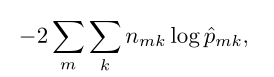
where n mk is the number of observations in the mth terminal node that
belong to the kth class. A small deviance indicates a tree that provides
a good fit to the (training) data. The residual mean deviance reported is
simply the deviance divided by n−|T 0 |

In [14]:
#对应Residual mean deviance :
ysample_1 = tree_clf.tree_.value[:,0][:,0]
ysample_2 = tree_clf.tree_.value[:,0][:,1]
yprob_1 = tree_clf.tree_.value[:,0][:,0]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
yprob_2 = tree_clf.tree_.value[:,0][:,1]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
y_1_index = (tree_clf.tree_.children_left == -1) & (yprob_1 != 0)
y_2_index = (tree_clf.tree_.children_left == -1) & (yprob_2 != 0)
deviance_compute = -2 * (np.sum(ysample_1[y_1_index] * np.log(yprob_1[y_1_index])) 
                               + np.sum(ysample_2[y_2_index] * np.log(yprob_2[y_2_index])))
print('Residual mean deviance : {:.4f} = {:.1f} / 373'.format(deviance_compute/373,deviance_compute))

Residual mean deviance : 0.4636 = 172.9 / 373


> plot(tree.carseats )

> text(tree.carseats ,pretty =0)

> tree.carseats

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


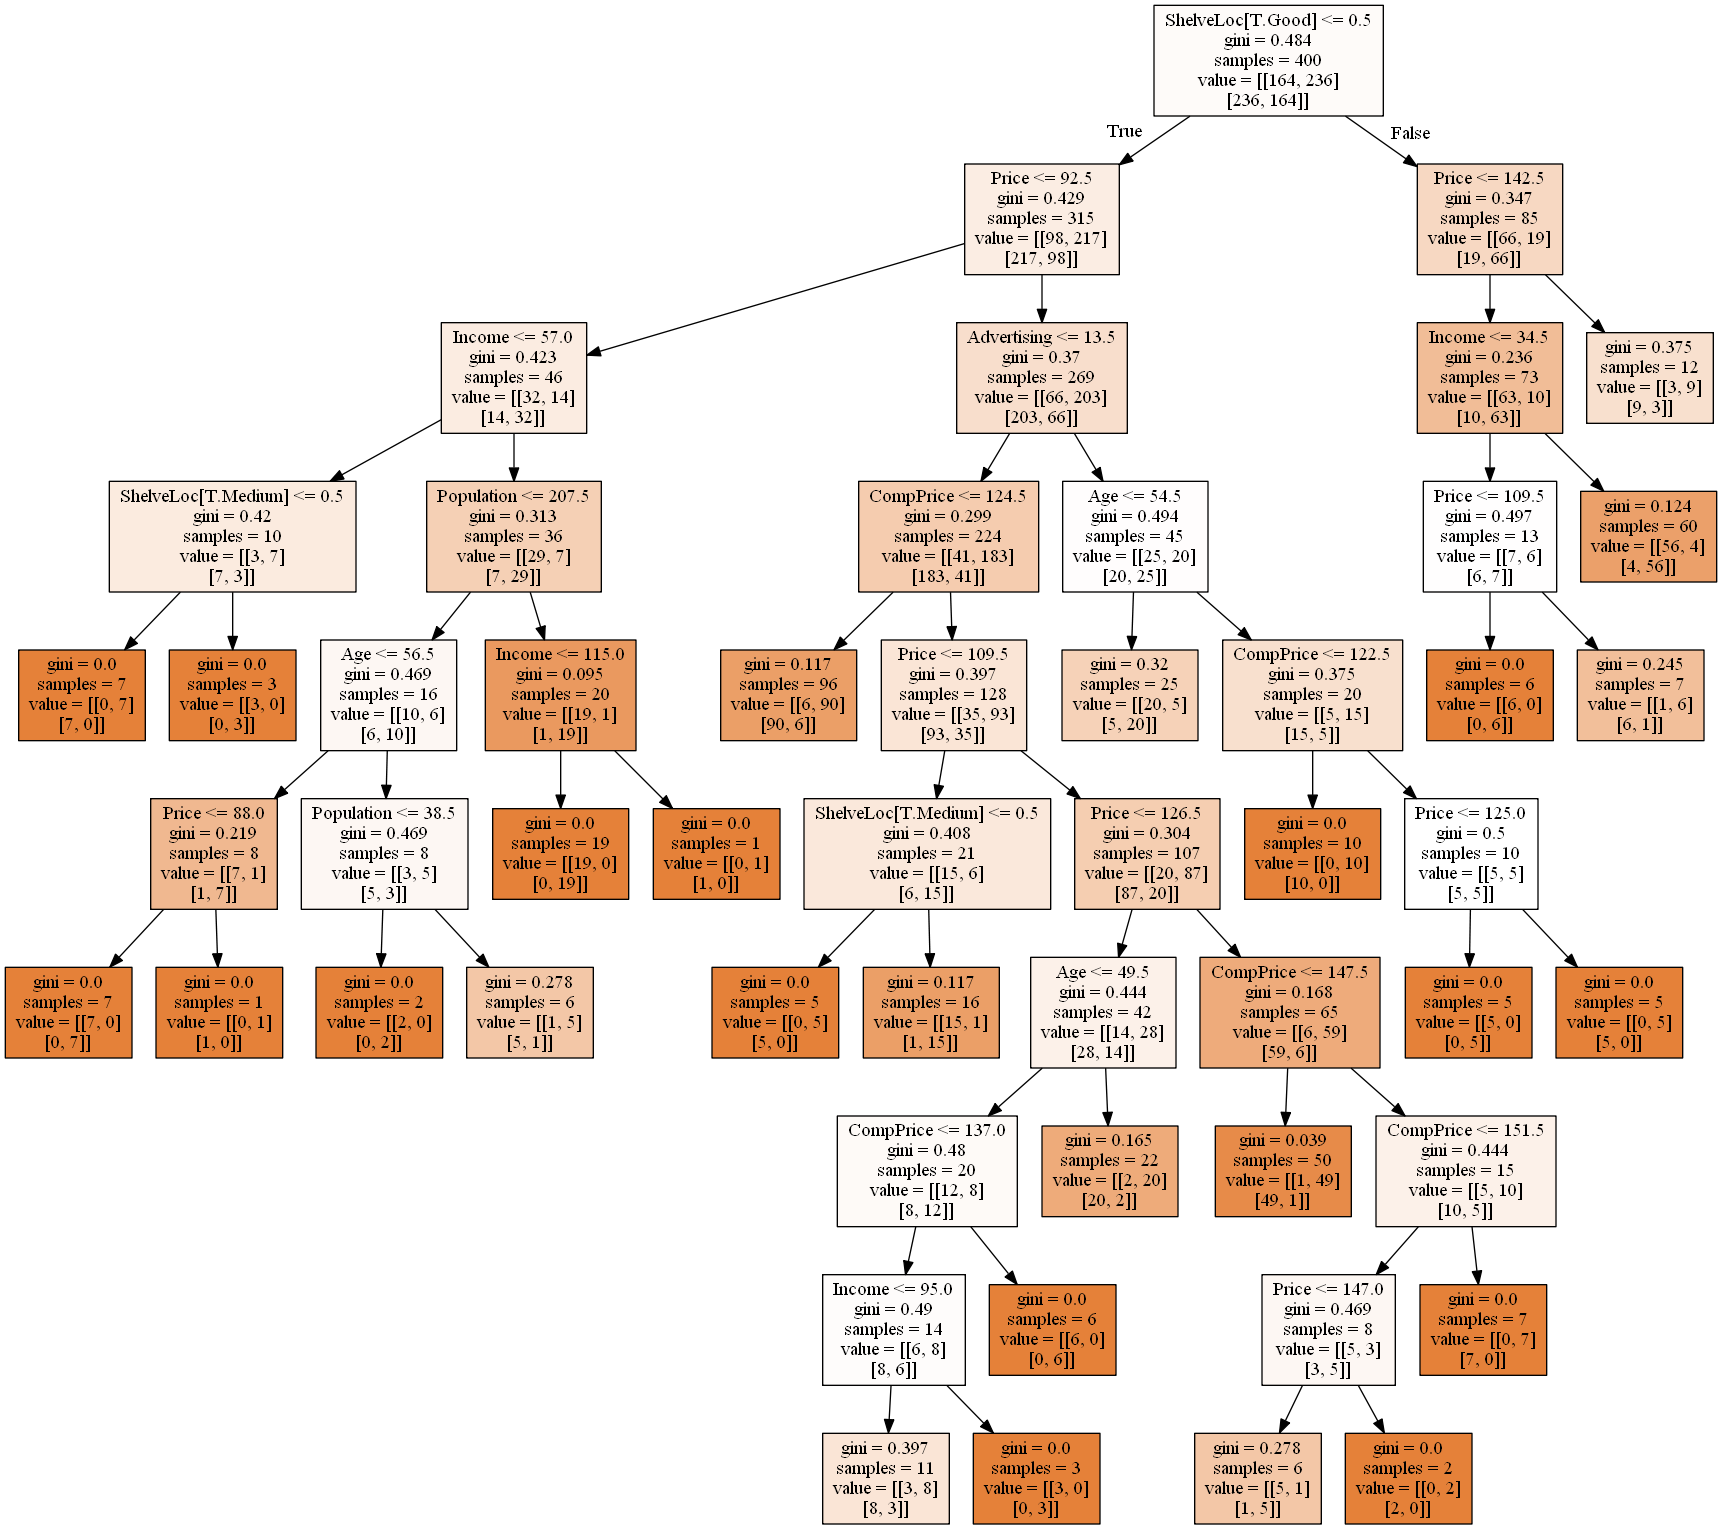

In [15]:
#实现方案1，参照https://github.com/JWarmenhoven/ISLR-python
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydot
# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)
graph1, = print_tree(tree_clf, features=X.columns, class_names=y.columns)
Image(graph1.create_png())

In [16]:
#实现方案2，参照https://github.com/DeqianBai/Hands-on-Machine-Learning
from sklearn.tree import export_graphviz
import os
# Where to save the figures
PROJECT_ROOT_DIR = "D:\MyPythonScripts\统计学导论实践及习题"
CHAPTER_ID = "08_Tree-Based Methods"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

export_graphviz(
    tree_clf,
    out_file=image_path("lab1_tree.dot"),
    feature_names=X.columns,
    class_names=y.columns,
    rounded=True,
    filled=True
)
os.popen('''cd /d {} && dot -Tpng lab1_tree.dot -o lab1_tree.png'''.format(image_path('')))


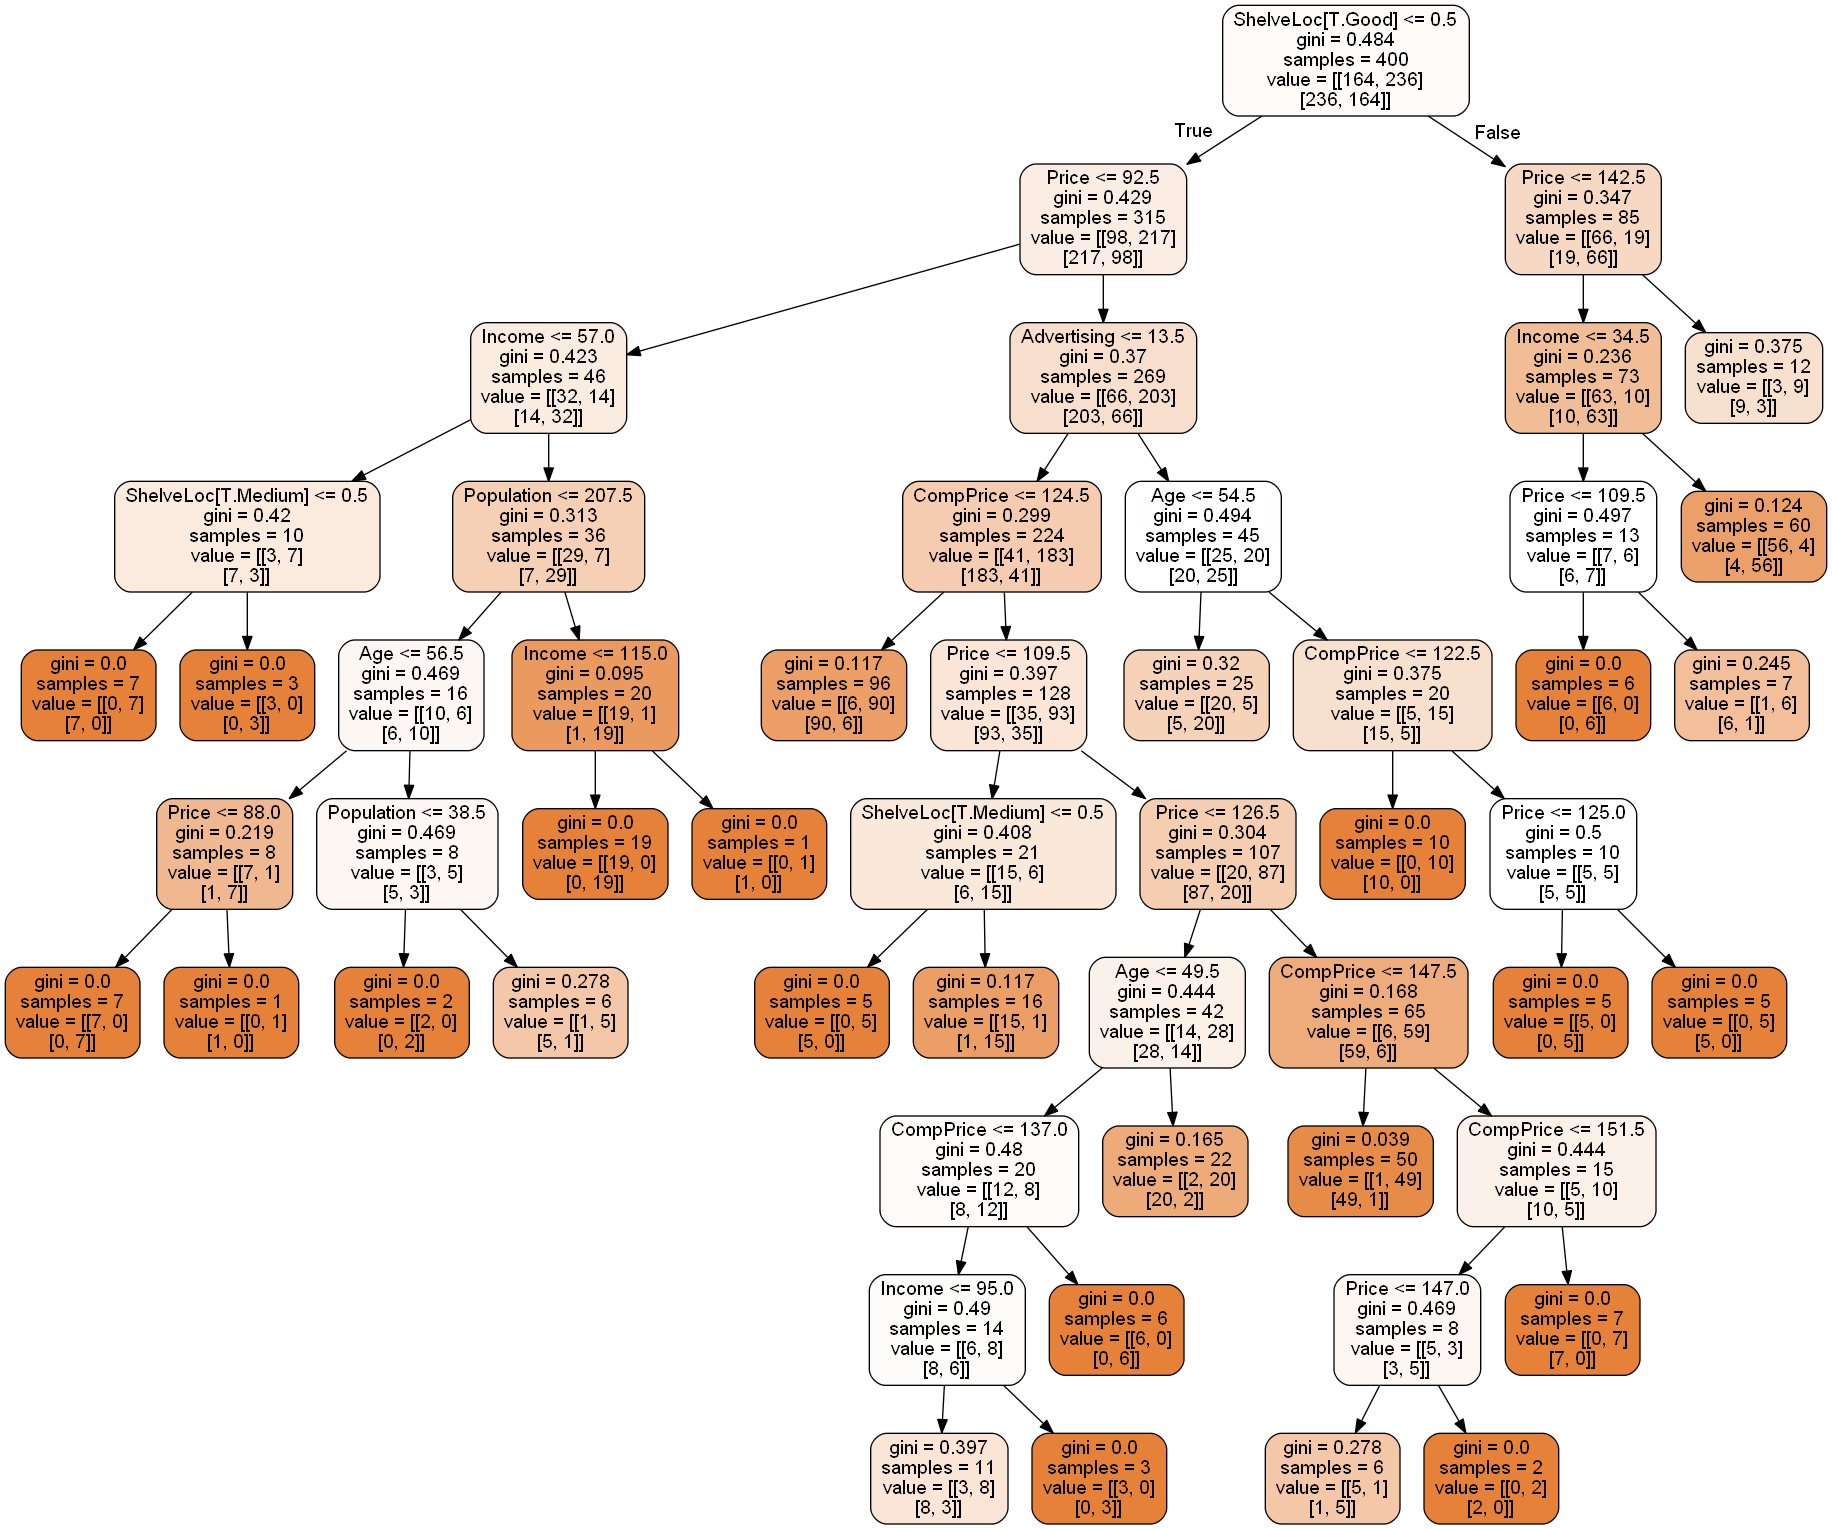

In [17]:
from IPython.display import Image
Image(filename=
      image_path("lab1_tree.png"),
      width=1800,height=1800,)

> tree.carseats

In [18]:
n_nodes = tree_clf.tree_.node_count
children_left = tree_clf.tree_.children_left
children_right = tree_clf.tree_.children_right
feature = tree_clf.tree_.feature
threshold = tree_clf.tree_.threshold
samples_num = tree_clf.tree_.n_node_samples
yprob_1 = tree_clf.tree_.value[:,0][:,0]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
yprob_2 = tree_clf.tree_.value[:,0][:,1]/(tree_clf.tree_.value[:,0][:,0] + tree_clf.tree_.value[:,0][:,1])
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)] # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1
    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True
print("The binary tree structure has %s nodes and has ""the following tree structure:"% n_nodes)

for i in range(n_nodes):
    if is_leaves[i]:
        print("%snode=%s leaf node n = %s prob = (%s %s)." % (node_depth[i]*"\t",
                                                              i,
                                                             samples_num[i],
                                                             yprob_1[i].round(3),
                                                             yprob_2[i].round(3)))
    else:
        print("%snode=%s test node n = %s prob = (%s %s): go to node %s if %s <= %s else to "
            "node %s."
            % (node_depth[i]*"\t",
            i,
            samples_num[i],
            yprob_1[i].round(3),
            yprob_2[i].round(3),
            children_left[i],
            X.columns[feature[i]],
            threshold[i],
            children_right[i],
            ))
print()

The binary tree structure has 53 nodes and has the following tree structure:
node=0 test node n = 400 prob = (0.41 0.59): go to node 1 if ShelveLoc[T.Good] <= 0.5 else to node 2.
	node=1 test node n = 315 prob = (0.311 0.689): go to node 3 if Price <= 92.5 else to node 4.
	node=2 test node n = 85 prob = (0.776 0.224): go to node 7 if Price <= 142.5 else to node 8.
		node=3 test node n = 46 prob = (0.696 0.304): go to node 17 if Income <= 57.0 else to node 18.
		node=4 test node n = 269 prob = (0.245 0.755): go to node 5 if Advertising <= 13.5 else to node 6.
			node=5 test node n = 224 prob = (0.183 0.817): go to node 11 if CompPrice <= 124.5 else to node 12.
			node=6 test node n = 45 prob = (0.556 0.444): go to node 9 if Age <= 54.5 else to node 10.
		node=7 test node n = 73 prob = (0.863 0.137): go to node 21 if Income <= 34.5 else to node 22.
		node=8 leaf node n = 12 prob = (0.25 0.75).
				node=9 leaf node n = 25 prob = (0.8 0.2).
				node=10 test node n = 20 prob = (0.25 0.75): 

> set.seed(2)

> train=sample(1:nrow(Carseats ), 200)

> Carseats .test=Carseats [-train ,]

> High.test=High[-train]

> tree.carseats =tree(High∼.-Sales ,Carseats ,subset=train)

> tree.pred=predict(tree.carseats ,Carseats .test,type="class")

> table(tree.pred ,High.test)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
np.random.seed(2)
train_set, test_set = train_test_split(Carseats, test_size = 0.5, random_state = 2)
y_test,X_test = patsy.dmatrices('High ~ {} - Sales - High'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('High ~ {} - Sales - High'.format(columns), train_set, return_type = 'dataframe')
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train['High[Yes]'])
tree_pred = tree_clf.predict(X_test)
confusion_matrix(y_test['High[Yes]'],tree_pred)
#python生成的是[['TN','FP']['FN','TP']],与R互倒
tree_pred_table = pd.DataFrame(confusion_matrix(y_test['High[Yes]'],tree_pred).T,
                             index = ['No','Yes'],
                             columns = [['High.test','High.test'],['No','Yes']])
tree_pred_table.columns.names = ['','tree.pred']
tree_pred_table       

High.test    
tree.pred        No Yes
No               95  18
Yes              31  56

In [20]:
(tree_clf.tree_.children_left == -1).sum()

36

In [21]:
print('({}+{})/200 = {:.3f}'.format(tree_pred_table.iloc[0,0],
                                tree_pred_table.iloc[1,1],
                                (tree_pred_table.iloc[0,0] + tree_pred_table.iloc[1,1])/200))

(95+56)/200 = 0.755


> set.seed(3)

> cv.carseats =cv.tree(tree.carseats ,FUN=prune.misclass )

不知道R语言的prune.misclass如何应用在python里，这里尝试使用min_samples_leaf超参数来进行CV选择

In [22]:
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import make_scorer
#from sklearn.metrics import accuracy_score
np.random.seed(3)
#param_range = np.linspace(-3, -2, 8)
param_range = np.arange(1,10)
tree_clf = DecisionTreeClassifier()
#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
param_grid = [
#{'min_impurity_decrease': 5 * 10 ** param_range },
{'min_samples_leaf': param_range },
]
#grid_search = GridSearchCV(tree_clf , param_grid, cv = 10, scoring=scoring,refit='AUC',return_train_score=True)
grid_search = GridSearchCV(tree_clf , param_grid, cv = 10, scoring='accuracy',return_train_score=True)
grid_search.fit(X_train ,y_train['High[Yes]'])

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 

In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.68 {'min_samples_leaf': 1}
0.705 {'min_samples_leaf': 2}
0.6900000000000001 {'min_samples_leaf': 3}
0.6950000000000001 {'min_samples_leaf': 4}
0.6950000000000001 {'min_samples_leaf': 5}
0.7100000000000002 {'min_samples_leaf': 6}
0.69 {'min_samples_leaf': 7}
0.6799999999999999 {'min_samples_leaf': 8}
0.6799999999999999 {'min_samples_leaf': 9}


In [24]:
grid_search.best_params_

{'min_samples_leaf': 6}

In [25]:
size_list = []
for param in param_range:
    tree_clf = DecisionTreeClassifier(min_samples_leaf = param)
    tree_clf.fit(X_train ,y_train['High[Yes]'])
    size_list.append((tree_clf.tree_.children_left == -1).sum())
    print("'min_samples_leaf' :{}  size: {}".format(param,(tree_clf.tree_.children_left == -1).sum()))

'min_samples_leaf' :1  size: 36
'min_samples_leaf' :2  size: 30
'min_samples_leaf' :3  size: 28
'min_samples_leaf' :4  size: 24
'min_samples_leaf' :5  size: 21
'min_samples_leaf' :6  size: 20
'min_samples_leaf' :7  size: 18
'min_samples_leaf' :8  size: 16
'min_samples_leaf' :9  size: 14


In [26]:
tree_clf = DecisionTreeClassifier(min_samples_leaf=grid_search.best_params_['min_samples_leaf'])
tree_clf.fit(X_train, y_train['High[Yes]'])
tree_pred = tree_clf.predict(X_test)
confusion_matrix(y_test['High[Yes]'],tree_pred)
#python生成的是[['TN','FP']['FN','TP']],与R互倒
tree_pred_table = pd.DataFrame(confusion_matrix(y_test['High[Yes]'],tree_pred).T,
                             index = ['No','Yes'],
                             columns = [['High.test','High.test'],['No','Yes']])
tree_pred_table.columns.names = ['','tree.pred']
tree_pred_table   

High.test    
tree.pred        No Yes
No              111  26
Yes              15  48

In [27]:
print('({}+{})/200 = {:.3f}'.format(tree_pred_table.iloc[0,0],
                                tree_pred_table.iloc[1,1],
                                (tree_pred_table.iloc[0,0] + tree_pred_table.iloc[1,1])/200))

(111+48)/200 = 0.795


In [28]:
tree_clf = DecisionTreeClassifier(min_samples_leaf=grid_search.best_params_['min_samples_leaf'] - 3)
tree_clf.fit(X_train, y_train['High[Yes]'])
tree_pred = tree_clf.predict(X_test)
confusion_matrix(y_test['High[Yes]'],tree_pred)
#python生成的是[['TN','FP']['FN','TP']],与R互倒
tree_pred_table = pd.DataFrame(confusion_matrix(y_test['High[Yes]'],tree_pred).T,
                             index = ['No','Yes'],
                             columns = [['High.test','High.test'],['No','Yes']])
tree_pred_table.columns.names = ['','tree.pred']
tree_pred_table   

High.test    
tree.pred        No Yes
No               98  22
Yes              28  52

In [29]:
print('({}+{})/200 = {:.3f}'.format(tree_pred_table.iloc[0,0],
                                tree_pred_table.iloc[1,1],
                                (tree_pred_table.iloc[0,0] + tree_pred_table.iloc[1,1])/200))

(98+52)/200 = 0.750


> par(mfrow=c(1,2))

> plot(cv.carseats$size ,cv.carseats$dev ,type="b")

> plot(cv.carseats$k ,cv.carseats$dev ,type="b")

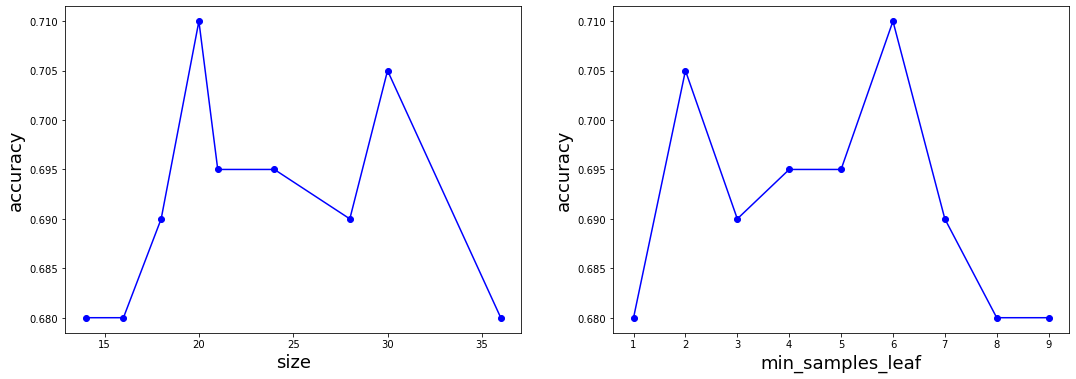

In [30]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
plt.plot(size_list,cvres["mean_test_score"],'b-o')
plt.xlabel(u"size", fontsize=18)
plt.ylabel(u"accuracy", fontsize=18)
plt.subplot(122)
plt.plot(param_range,cvres["mean_test_score"],'b-o')
plt.xlabel(u"min_samples_leaf", fontsize=18)
plt.ylabel(u"accuracy", fontsize=18)
plt.show()

**8.3.2 Fitting Regression Trees**

> library(MASS)

> set.seed(1)

> train = sample(1:nrow(Boston), nrow(Boston)/2)

> tree.boston=tree(medv∼.,Boston ,subset=train)

> summary(tree.boston)

In [31]:
Boston = pd.read_csv("data/Boston.csv")
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [32]:
columns = '1'
for column in Boston.columns:
    columns = columns + '+' + column
np.random.seed(1)
train_set, test_set = train_test_split(Boston, test_size = 0.5, random_state = 1)
y_test,X_test = patsy.dmatrices('medv ~ {} - medv'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('medv ~ {} - medv'.format(columns), train_set, return_type = 'dataframe')
X_train.drop('Intercept',axis = 1,inplace= True)
X_test.drop('Intercept',axis = 1,inplace= True)

In [33]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_leaf_nodes = 8)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=8,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [34]:
tree_reg.tree_.node_count

15

In [35]:
#对应Variables actually used in tree construction:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':tree_reg.feature_importances_})
feature_importance[feature_importance['importance'] != 0].sort_values(by='importance', ascending=False)

,feature,importance
12,lstat,0.656101
5,rm,0.238342
7,dis,0.086503
0,crim,0.019054


In [36]:
#对应Number of terminal nodes:
(tree_reg.tree_.children_left == -1).sum()

8

In [37]:
Distribution_of_residuals = y_train - pd.DataFrame(tree_reg.predict(X_train),columns = y_train.columns,index = y_train.index)

In [38]:
#对应Residual mean deviance : 
print('{:.2f} = {:.2f}/245'.format(np.sum(Distribution_of_residuals.values ** 2)/245,
    np.sum(Distribution_of_residuals.values ** 2)))

11.32 = 2773.18/245


In [39]:
#对应Distribution of residuals :
Distribution_of_residuals.describe().round(2)

,medv
count,253.00
mean,-0.00
std,3.32
min,-8.87
25%,-2.23
50%,-0.13
75%,1.93
max,11.97


> plot(tree.boston)

> text(tree.boston ,pretty=0)

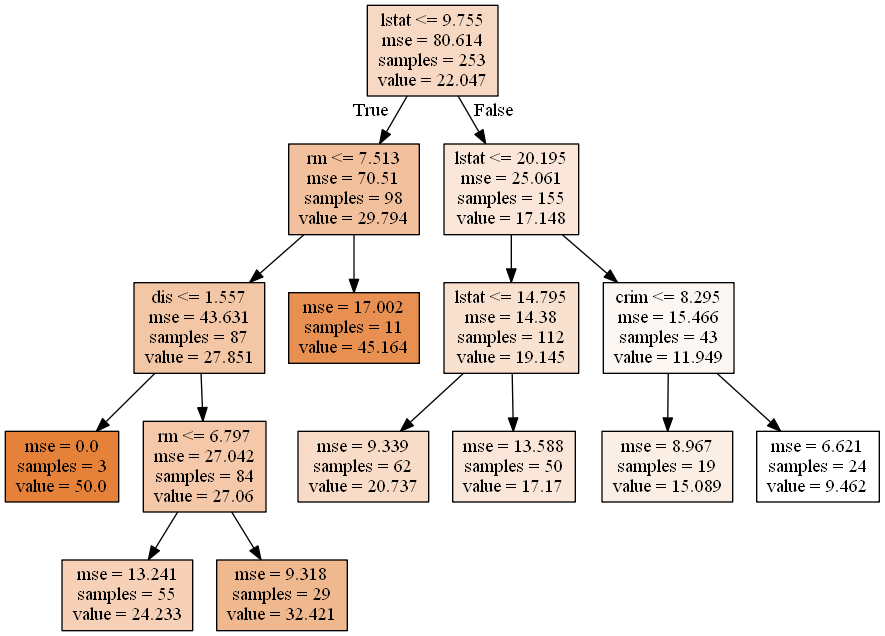

In [40]:
#实现方案1，参照https://github.com/JWarmenhoven/ISLR-python
graph2, = print_tree(tree_reg, features=X_train.columns, class_names=y_train.columns)
Image(graph2.create_png())

In [41]:
#实现方案2，参照https://github.com/DeqianBai/Hands-on-Machine-Learning
export_graphviz(
    tree_reg,
    out_file=image_path("lab2_tree.dot"),
    feature_names=X_train.columns,
    class_names=y_train.columns,
    rounded=True,
    filled=True
)
os.popen('''cd /d {} && dot -Tpng lab2_tree.dot -o lab2_tree.png'''.format(image_path('')))

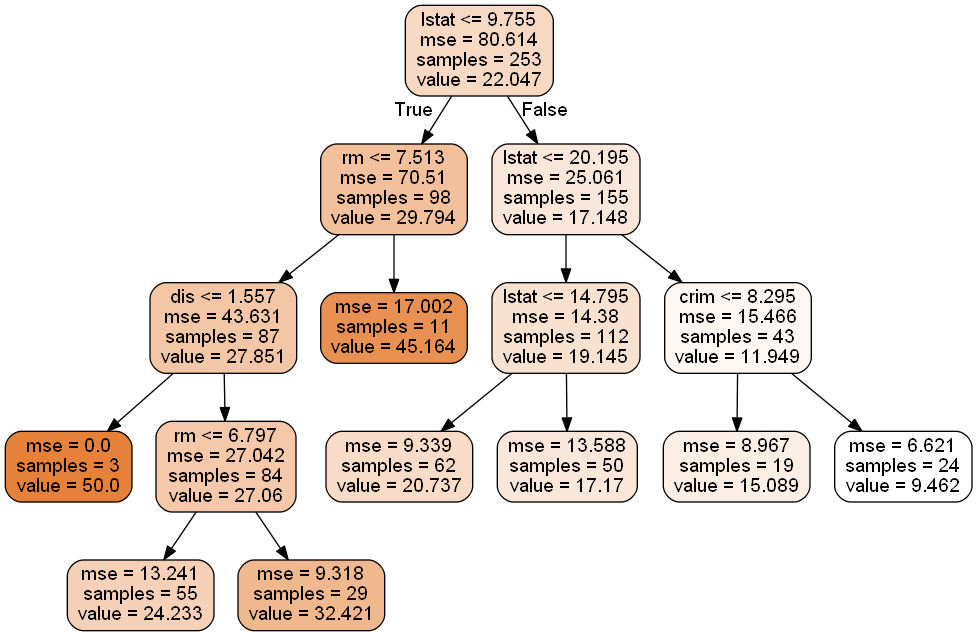

In [42]:
from IPython.display import Image
Image(filename=
      image_path("lab2_tree.png"),
      width=1800,height=1800,)

> cv.boston=cv.tree(tree.boston)

> plot(cv.boston$size ,cv.boston$dev ,type=’b’)

> prune.boston=prune.tree(tree.boston ,best=5)

> plot(prune.boston)

> text(prune.boston ,pretty=0)

In [43]:
param_range = np.arange(1,10)
tree_reg = DecisionTreeRegressor()
param_grid = [
{'min_samples_leaf': param_range },
]
grid_search = GridSearchCV(tree_reg , param_grid, cv = 10, scoring='neg_mean_squared_error',return_train_score=True)
grid_search.fit(X_train ,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=T

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

-28.75336615384615 {'min_samples_leaf': 1}
-26.187830213675216 {'min_samples_leaf': 2}
-24.419865330769227 {'min_samples_leaf': 3}
-21.211466000784927 {'min_samples_leaf': 4}
-23.507593184365852 {'min_samples_leaf': 5}
-20.665553230123752 {'min_samples_leaf': 6}
-21.7495727505833 {'min_samples_leaf': 7}
-22.50223716645774 {'min_samples_leaf': 8}
-23.08013578007616 {'min_samples_leaf': 9}


In [45]:
grid_search.best_params_

{'min_samples_leaf': 6}

In [46]:
size_list = []
for param in param_range:
    tree_reg = DecisionTreeRegressor(min_samples_leaf = param)
    tree_reg.fit(X_train ,y_train)
    size_list.append((tree_reg.tree_.children_left == -1).sum())
    print("'min_samples_leaf' :{}  size: {}".format(param,(tree_reg.tree_.children_left == -1).sum()))

'min_samples_leaf' :1  size: 240
'min_samples_leaf' :2  size: 108
'min_samples_leaf' :3  size: 71
'min_samples_leaf' :4  size: 51
'min_samples_leaf' :5  size: 41
'min_samples_leaf' :6  size: 34
'min_samples_leaf' :7  size: 30
'min_samples_leaf' :8  size: 25
'min_samples_leaf' :9  size: 24


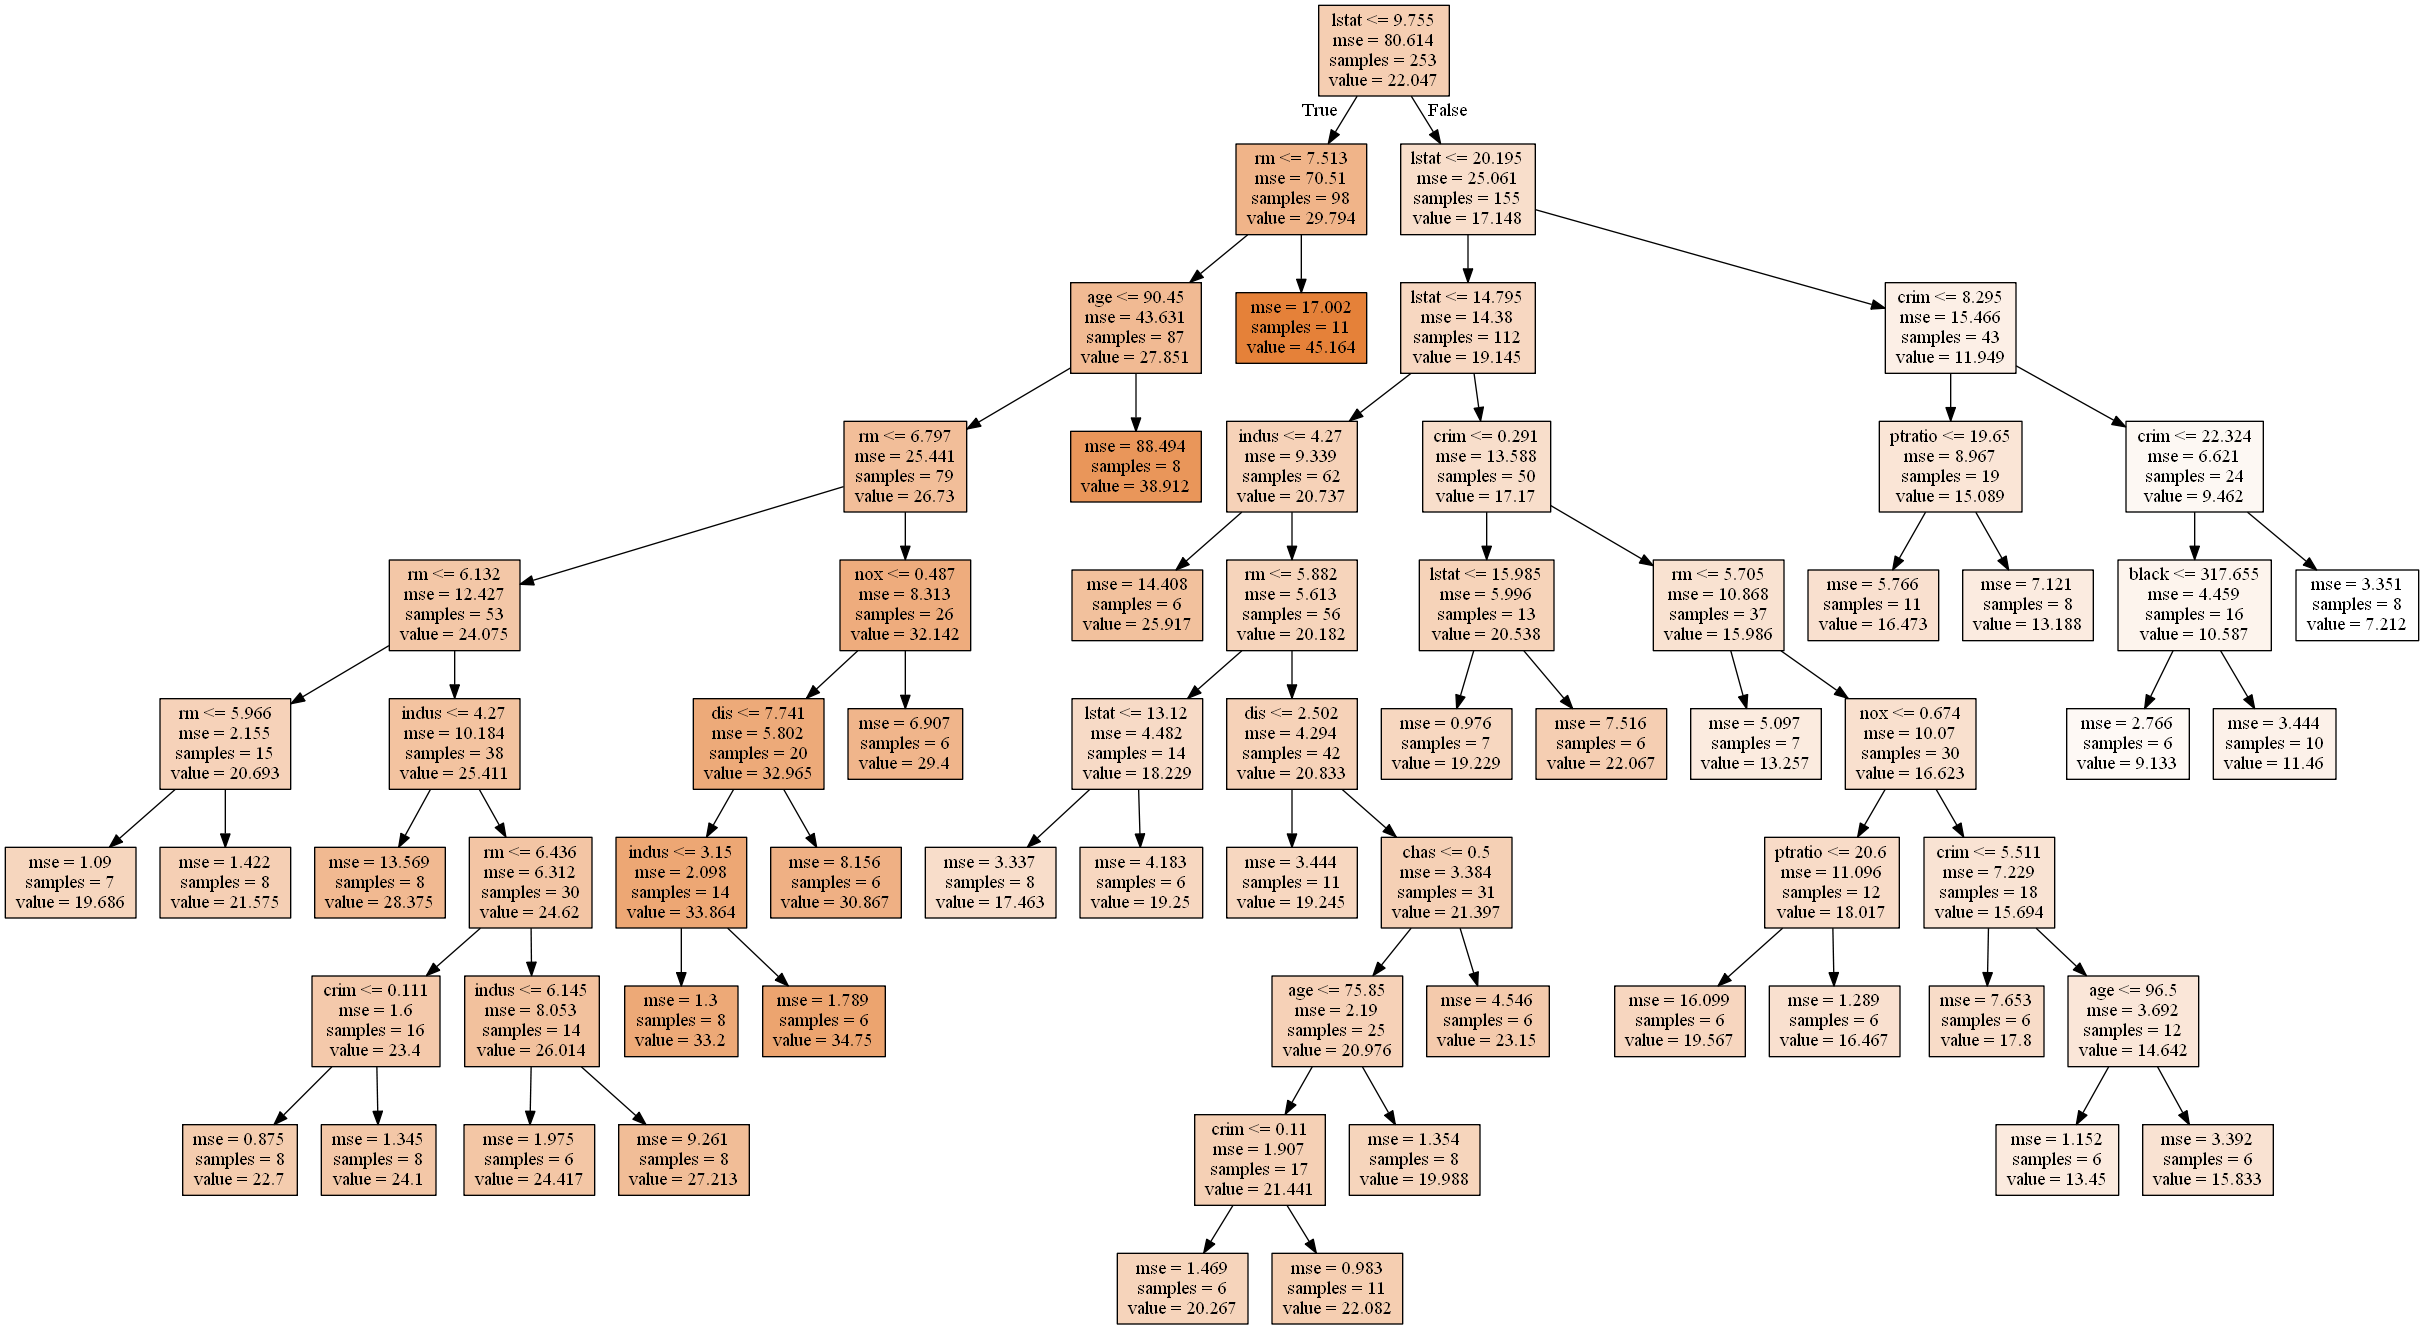

In [47]:
tree_reg = DecisionTreeRegressor(min_samples_leaf = grid_search.best_params_['min_samples_leaf'])
tree_reg.fit(X_train ,y_train)
graph3, = print_tree(tree_reg, features=X_train.columns, class_names=y_train.columns)
Image(graph3.create_png())

> yhat=predict(tree.boston ,newdata=Boston[-train ,])

> boston.test=Boston[-train ,"medv"]

> plot(yhat ,boston.test)

> abline(0,1)

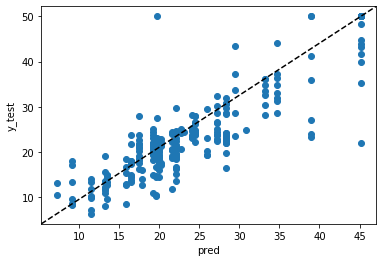

In [48]:
y_hat = tree_reg.predict(X_test)
plt.scatter(y_hat,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

> mean((yhat-boston.test)^2)

In [49]:
((y_hat - y_test.values.flatten()) ** 2).mean().round(2)

24.21

**8.3.3 Bagging and Random Forests**

> library(randomForest)

> set.seed(1)

> bag.boston=randomForest(medv∼.,data=Boston ,subset=train ,
mtry=13,importance =TRUE)

> bag.boston

In [50]:
#可以使用已有的sklearn Bagging API，但是这里需要引用 DecisionTreeRegressor API
from sklearn.ensemble import BaggingRegressor
np.random.seed(1)
bag_reg = BaggingRegressor(DecisionTreeRegressor(),n_estimators=500,oob_score=True, random_state=1)
bag_reg.fit(X_train,y_train.values.ravel())

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features=None,
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=None,
                                                      splitter='best'),
                 bootstrap=T

In [51]:
#对应Mean of squared residuals : 
((bag_reg.predict(X_train)- y_train.values.flatten()) ** 2).mean().round(2)

2.03

In [52]:
#对应% Var explained :
from sklearn.metrics import r2_score
r2_score(y_train.values.flatten(),bag_reg.predict(X_train))

0.9748007996232387

In [53]:
#对应% Var explained :
bag_reg.oob_score_

0.8233195947064137

> yhat.bag = predict(bag.boston ,newdata=Boston[-train ,])

> plot(yhat.bag, boston.test)

> abline(0,1)

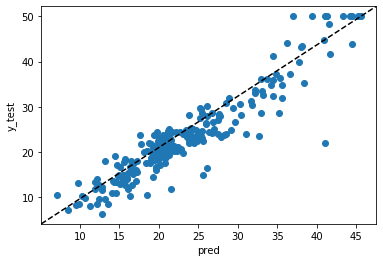

In [54]:
y_hat_bag = bag_reg.predict(X_test)
plt.scatter(y_hat_bag,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

> mean((yhat.bag-boston.test)^2)

In [55]:
((y_hat_bag - y_test.values.flatten()) ** 2).mean().round(2)

11.72

In [56]:
#这里可以使max_features=13来同样实现Bagging
from sklearn.ensemble import RandomForestRegressor
np.random.seed(1)
bag_rf_reg = RandomForestRegressor(n_estimators=500,oob_score=True,max_features=13, random_state=1)
bag_rf_reg.fit(X_train,y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=13, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=True,
                      random_state=1, verbose=0, warm_start=False)

In [57]:
#对应Mean of squared residuals : 
((bag_rf_reg.predict(X_train)- y_train.values.flatten()) ** 2).mean().round(2)

2.02

In [58]:
#对应% Var explained :
r2_score(y_train.values.flatten(),bag_rf_reg.predict(X_train))

0.9749597742205862

In [59]:
#对应% Var explained :
bag_rf_reg.oob_score_

0.8233185193707468

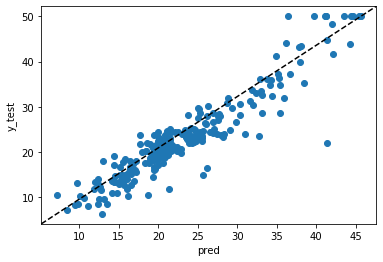

In [60]:
y_hat_bag_rf = bag_rf_reg.predict(X_test)
plt.scatter(y_hat_bag_rf,y_test)
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.xlabel('pred')
plt.ylabel('y_test')
plt.show()

In [61]:
((y_hat_bag_rf - y_test.values.flatten()) ** 2).mean().round(2)

11.79

> set.seed(1)

> rf.boston=randomForest(medv∼.,data=Boston ,subset=train ,
mtry=6,importance =TRUE)

> yhat.rf = predict(rf.boston ,newdata=Boston[-train ,])

> mean((yhat.rf-boston.test)^2)

In [62]:
np.random.seed(1)
rf_reg = RandomForestRegressor(n_estimators=500,oob_score=True,max_features=6, random_state=1)
rf_reg.fit(X_train,y_train.values.ravel())
((rf_reg.predict(X_test)- y_test.values.flatten()) ** 2).mean().round(2)

11.56

> importance (rf.boston)

In [63]:
#这里无法输出IncNodePurity
feature_importance=pd.DataFrame({'feature':X_train.columns, '%IncMSE':(rf_reg.feature_importances_ * 100).round(3)})
feature_importance

,feature,%IncMSE
0,crim,5.708
1,zn,0.485
2,indus,6.000
3,chas,0.140
4,nox,5.637
5,rm,27.342
6,age,2.748
7,dis,6.581
8,rad,0.646
9,tax,1.798


> varImpPlot (rf.boston)

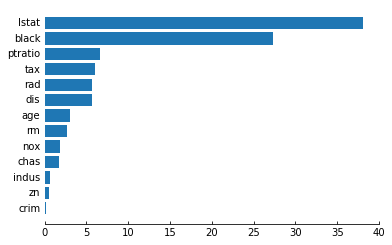

In [64]:
from mpl_toolkits.axisartist.axislines import SubplotZero
feature_importance.sort_values('%IncMSE', inplace=True)
fig = plt.figure()
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)
for direction in ["left","right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.barh(feature_importance['feature'],width = feature_importance['%IncMSE'])
for i in range(len(feature_importance['feature'])):
    ax.text(-0.5,i ,feature_importance['feature'][i],horizontalalignment='right', verticalalignment='center')
plt.show()

**8.3.4 Boosting**

> library(gbm)

> set.seed(1)

> boost.boston=gbm(medv∼.,data=Boston[train ,],distribution=
"gaussian ",n.trees=5000, interaction .depth=4)

In [65]:
from  sklearn.ensemble import GradientBoostingRegressor
gbm =GradientBoostingRegressor(n_estimators = 5000,max_depth = 4,learning_rate=0.01,random_state = 1)
gbm.fit(X_train,y_train.values.ravel())

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

> summary(boost.boston)

In [66]:
feature_importance=pd.DataFrame({'feature':X_train.columns, 'rel.inf':(gbm.feature_importances_ * 100).round(3)})
feature_importance.sort_values('rel.inf', inplace=True,ascending=False)
feature_importance.set_index('feature',inplace=True)
feature_importance

,rel.inf
feature,
lstat,57.904
rm,22.050
dis,8.536
crim,2.854
ptratio,1.804
tax,1.757
nox,1.498
age,1.358
black,1.226


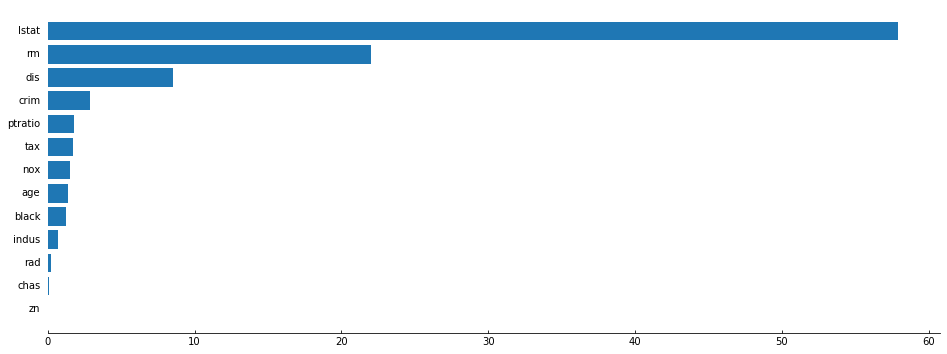

In [67]:
feature_importance.sort_values('rel.inf', inplace=True)
fig = plt.figure(figsize=[16,6])
ax = SubplotZero(fig, 111)
fig.add_subplot(ax)
for direction in ["left","right", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)
ax.barh(feature_importance.index ,width = feature_importance['rel.inf'])
for i in range(len(feature_importance.index)):
    ax.text(-0.5,i ,feature_importance.index[i],horizontalalignment='right', verticalalignment='center')
plt.show()

> par(mfrow=c(1,2))

> plot(boost.boston ,i="rm")

> plot(boost.boston ,i="lstat")

偏相关图未找到实现方案

> yhat.boost=predict(boost.boston ,newdata=Boston[-train ,],
n.trees=5000)

> mean((yhat.boost -boston.test)^2)

In [68]:
((gbm.predict(X_test)- y_test.values.flatten()) ** 2).mean().round(2)

10.19

> boost.boston=gbm(medv∼.,data=Boston[train ,],distribution=
"gaussian ",n.trees=5000, interaction .depth=4,shrinkage =0.2,
verbose=F)

> yhat.boost=predict(boost.boston ,newdata=Boston[-train ,],
n.trees=5000)

> mean((yhat.boost -boston.test)^2)

In [69]:
gbm_2 =GradientBoostingRegressor(n_estimators = 5000,max_depth = 4,learning_rate = 0.2, random_state = 1)
gbm_2.fit(X_train,y_train.values.ravel())
((gbm_2.predict(X_test)- y_test.values.flatten()) ** 2).mean().round(2)

10.06